In [6]:
# !pip -q install torch torchvision pandas matplotlib

import os, math, time, random
from dataclasses import dataclass
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib

%matplotlib inline
import matplotlib.pyplot as plt


# =========================
# Repro + device
# =========================
def set_seed(s):
    random.seed(s); np.random.seed(s)
    torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(hp.seed)

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

import os
OUTDIR = "./runs/mlp3_mnist"
os.makedirs(OUTDIR, exist_ok=True)

/var/folders/9q/8zt1k19s11j8ypmkfsv8qvyr0000gn/T/ipykernel_32919/3206604097.py:162: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=hp.amp and device.type=="cuda")


Epoch 01/40  train_loss 0.6706  train_acc 87.87%  test_acc 96.82%  LRs [0.0008, 0.0016]  (11.8s)
Epoch 02/40  train_loss 0.4720  train_acc 94.83%  test_acc 97.79%  LRs [0.0016, 0.0032]  (9.1s)
Epoch 03/40  train_loss 0.4690  train_acc 94.88%  test_acc 97.81%  LRs [0.0024, 0.0048]  (6.9s)
Epoch 04/40  train_loss 0.4665  train_acc 95.03%  test_acc 97.98%  LRs [0.002396, 0.004791]  (7.1s)
Epoch 05/40  train_loss 0.4430  train_acc 95.81%  test_acc 98.18%  LRs [0.002383, 0.004766]  (6.6s)
Epoch 06/40  train_loss 0.4262  train_acc 96.28%  test_acc 98.56%  LRs [0.002362, 0.004723]  (6.7s)
Epoch 07/40  train_loss 0.4159  train_acc 96.64%  test_acc 98.56%  LRs [0.002332, 0.004664]  (6.7s)
Epoch 08/40  train_loss 0.4068  train_acc 96.90%  test_acc 98.53%  LRs [0.002295, 0.004589]  (9.1s)
Epoch 09/40  train_loss 0.4048  train_acc 97.01%  test_acc 98.63%  LRs [0.002249, 0.004498]  (7.9s)
Epoch 10/40  train_loss 0.4000  train_acc 97.21%  test_acc 98.68%  LRs [0.002196, 0.004393]  (6.8s)
Epoch 11/40

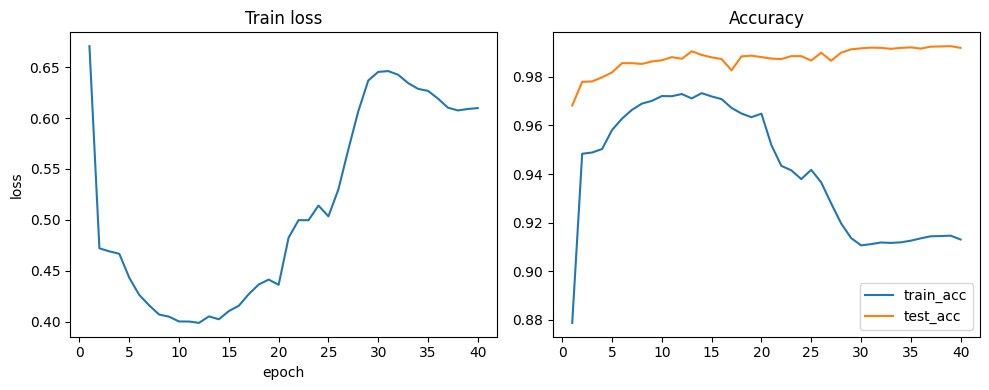

In [7]:
# =========================
# Hyperparameters
# =========================
@dataclass
class HParams:
    hidden1: int = 1792
    hidden2: int = 896
    dropout: float = 0.15

    epochs: int = 40
    batch_size: int = 256
    base_lr: float = 3e-3
    head_lr_mul: float = 1.6
    stem_lr_mul: float = 0.8
    weight_decay: float = 1.0e-4
    warmup_epochs: int = 3
    min_lr_ratio: float = 0.01
    label_smoothing: float = 0.05
    clip_grad_norm: float = 0.0

    # augmentation
    degrees: float = 10.0
    translate: tuple = (0.1, 0.1)
    scale: tuple = (0.95, 1.05)
    random_erasing: float = 0.05

    num_workers: int = 2
    seed: int = 42
    amp: bool = True
    out_dir: str = OUTDIR

hp = HParams()



# =========================
# Model
# =========================
class MLP3(nn.Module):
    def __init__(self, h1=1024, h2=512, drop=0.2):
        super().__init__()
        self.flatten = nn.Flatten()
        self.stem = nn.Sequential(
            nn.Linear(28*28, h1),
            nn.BatchNorm1d(h1),
            nn.ReLU(inplace=True),
            nn.Dropout(drop),
            nn.Linear(h1, h2),
            nn.BatchNorm1d(h2),
            nn.ReLU(inplace=True),
            nn.Dropout(drop),
        )
        self.head = nn.Linear(h2, 10)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.flatten(x)
        x = self.stem(x)
        x = self.head(x)
        return x

# =========================
# Scheduler: Warmup + Cosine
# =========================
class WarmupCosine:
    def __init__(self, opt, max_epochs, warmup, min_ratio=0.02):
        self.opt = opt; self.max = max_epochs; self.warm = warmup; self.min = min_ratio
        self.e = 0
        self.base = [pg.get("initial_lr", pg["lr"]) for pg in opt.param_groups]
    def step(self):
        self.e += 1
        for base, pg in zip(self.base, self.opt.param_groups):
            if self.e <= self.warm:
                lr = base * self.e / max(1, self.warm)
            else:
                t = (self.e - self.warm) / max(1, self.max - self.warm)
                lr = base * (self.min + 0.5*(1-self.min)*(1+math.cos(math.pi*t)))
            pg["lr"] = lr
    def get_lrs(self): return [pg["lr"] for pg in self.opt.param_groups]

# =========================
# Data
# =========================
train_tf = [
    transforms.RandomAffine(degrees=hp.degrees, translate=hp.translate, scale=hp.scale),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
]
if hp.random_erasing > 0:
    train_tf.append(transforms.RandomErasing(p=hp.random_erasing, scale=(0.02, 0.1), ratio=(0.3, 3.3)))

test_tf = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))])

train_ds = datasets.MNIST("./data", train=True, download=True, transform=transforms.Compose(train_tf))
test_ds  = datasets.MNIST("./data", train=False, download=True, transform=test_tf)
train_loader = DataLoader(train_ds, batch_size=hp.batch_size, shuffle=True,
                          num_workers=hp.num_workers, pin_memory=True, drop_last=True)
test_loader  = DataLoader(test_ds, batch_size=1024, shuffle=False,
                          num_workers=hp.num_workers, pin_memory=True)

# =========================
# Train & Eval
# =========================
def accuracy(logits, y):
    with torch.no_grad():
        return (logits.argmax(1) == y).float().mean().item()

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)
    return correct / total

def train_one_epoch(model, loader, opt, scaler):
    model.train()
    loss_fn = nn.CrossEntropyLoss(label_smoothing=hp.label_smoothing)
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad(set_to_none=True)
        if hp.amp:
            with torch.autocast(device_type=device.type, dtype=torch.float16 if device.type=="cuda" else torch.bfloat16):
                out = model(x)
                loss = loss_fn(out, y)
            scaler.scale(loss).backward()
            if hp.clip_grad_norm > 0:
                scaler.unscale_(opt)
                torch.nn.utils.clip_grad_norm_(model.parameters(), hp.clip_grad_norm)
            scaler.step(opt)
            scaler.update()
        else:
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            if hp.clip_grad_norm > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), hp.clip_grad_norm)
            opt.step()
        total_loss += loss.item()
        total_acc += accuracy(out, y)
        n += 1
    return total_loss/n, total_acc/n

# =========================
# Setup training
# =========================
model = MLP3(hp.hidden1, hp.hidden2, hp.dropout).to(device)
pgs = [
    {"params": list(model.stem.parameters()), "lr": hp.base_lr*hp.stem_lr_mul, "initial_lr": hp.base_lr*hp.stem_lr_mul, "weight_decay": hp.weight_decay},
    {"params": list(model.head.parameters()), "lr": hp.base_lr*hp.head_lr_mul, "initial_lr": hp.base_lr*hp.head_lr_mul, "weight_decay": hp.weight_decay}
]
opt = torch.optim.AdamW(pgs, betas=(0.9, 0.999), eps=1e-8)
sched = WarmupCosine(opt, hp.epochs, hp.warmup_epochs, hp.min_lr_ratio)
scaler = torch.cuda.amp.GradScaler(enabled=hp.amp and device.type=="cuda")

# =========================
# Run training
# =========================
best_acc, history = 0, []
t0 = time.time()
for epoch in range(1, hp.epochs+1):
    t1 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, opt, scaler)
    test_acc = evaluate(model, test_loader)
    sched.step()
    lrs = sched.get_lrs()
    history.append(dict(epoch=epoch, train_loss=train_loss, train_acc=train_acc, test_acc=test_acc,
                        lr_stem=lrs[0], lr_head=lrs[1]))
    print(f"Epoch {epoch:02d}/{hp.epochs}  train_loss {train_loss:.4f}  train_acc {train_acc*100:5.2f}%  "
          f"test_acc {test_acc*100:5.2f}%  LRs {[round(l,6) for l in lrs]}  ({time.time()-t1:.1f}s)")
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save({"model": model.state_dict(), "epoch": epoch, "acc": best_acc},
                   os.path.join(hp.out_dir, "model_best.pt"))

print(f"\nDone in {time.time()-t0:.1f}s. Best test acc: {best_acc*100:.2f}%")

# =========================
# Save logs & plot
# =========================
df = pd.DataFrame(history)
df.to_csv(os.path.join(hp.out_dir, "training_log.csv"), index=False)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(df["epoch"], df["train_loss"]); plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Train loss")
plt.subplot(1,2,2); plt.plot(df["epoch"], df["train_acc"], label="train_acc"); plt.plot(df["epoch"], df["test_acc"], label="test_acc"); plt.legend(); plt.title("Accuracy")
plt.tight_layout(); plt.savefig(os.path.join(hp.out_dir, "training_curves.png"), dpi=140)
print("Saved logs and plots in:", hp.out_dir)

PyTorch is available but CUDA is not. Defaulting to NumPy for SVD
Import error , resetting to svd accurate methods


Running on macOS.
Running on macOS.


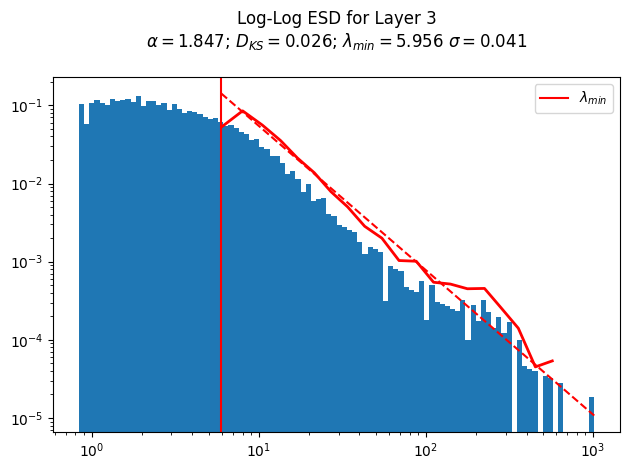

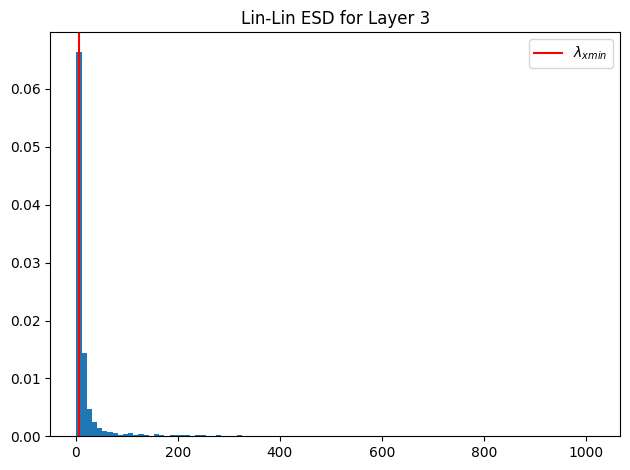

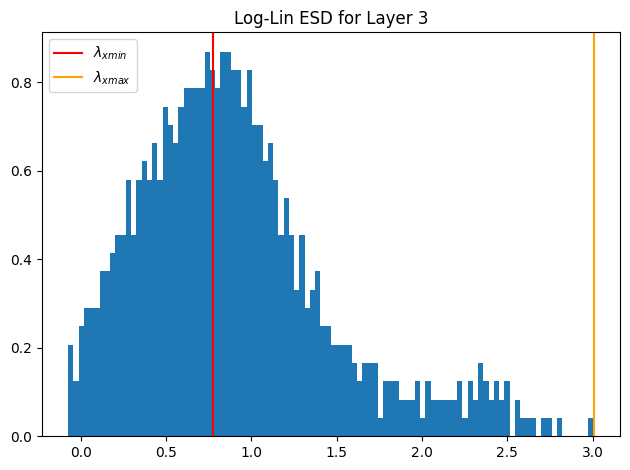

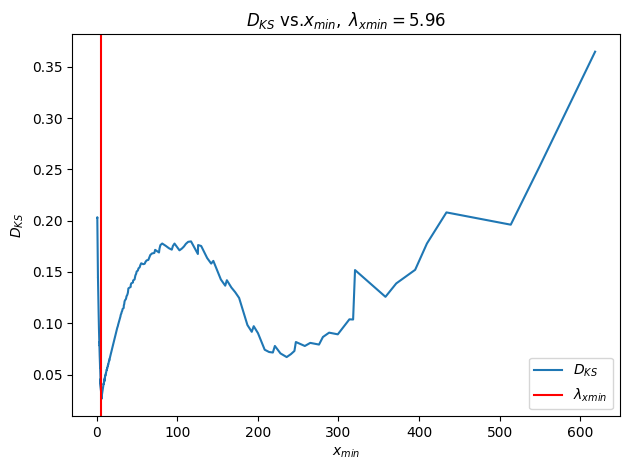

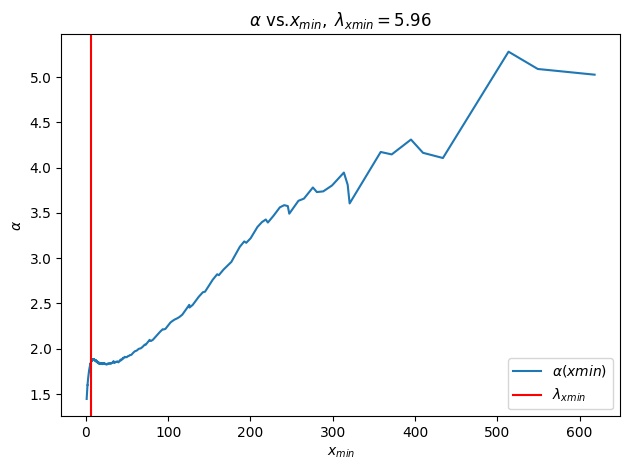

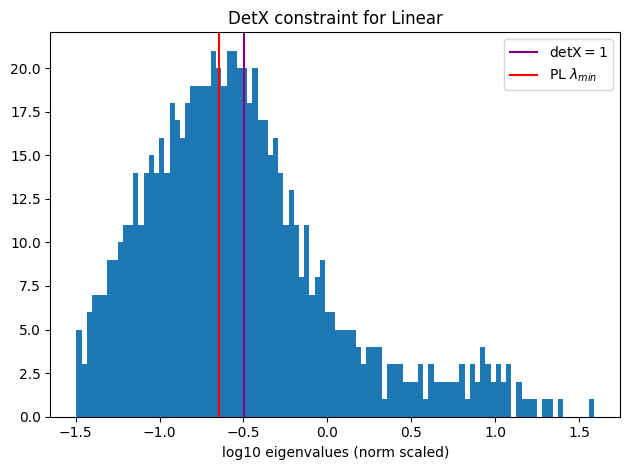

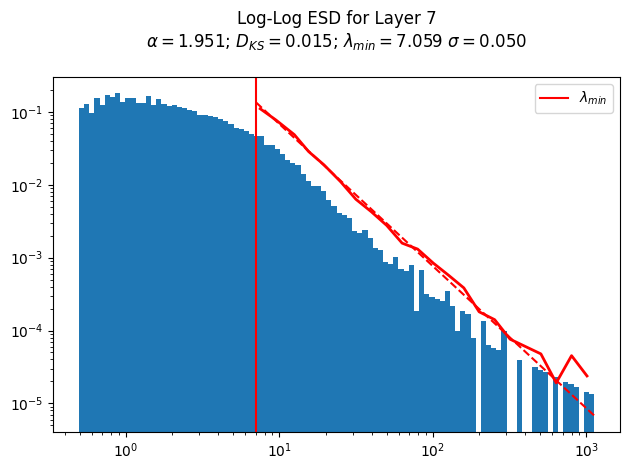

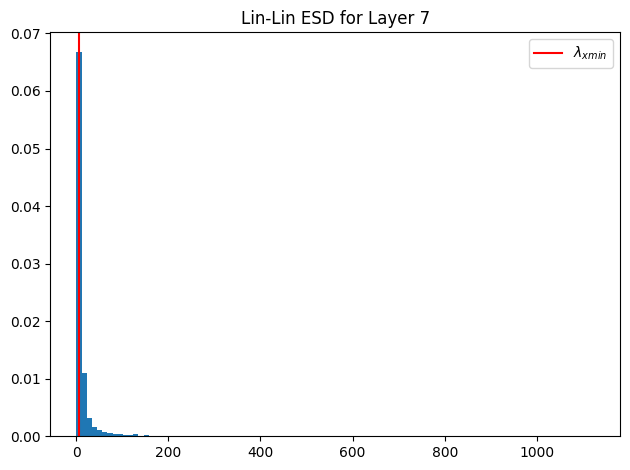

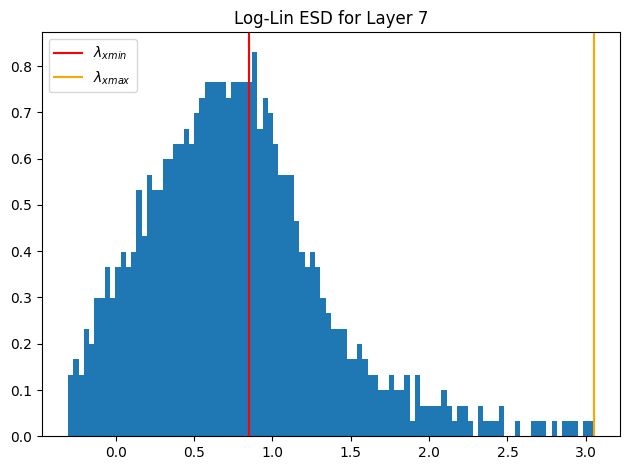

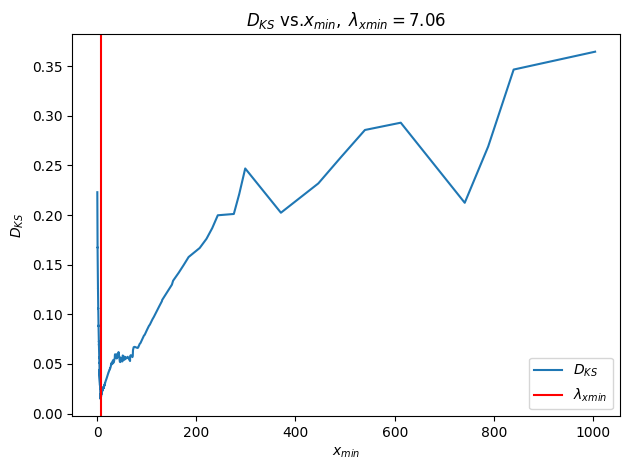

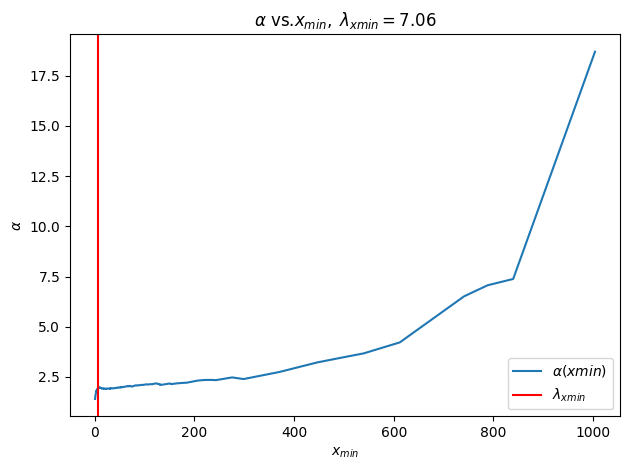

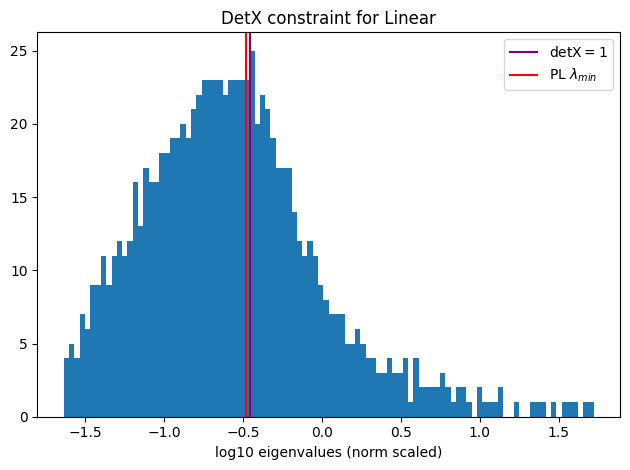

SMALL N PL FIT


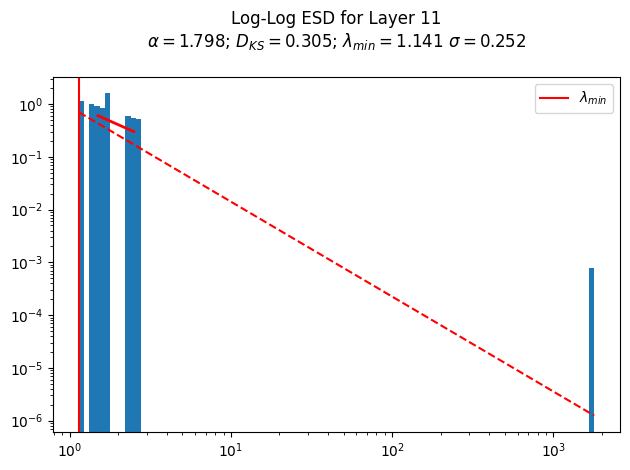

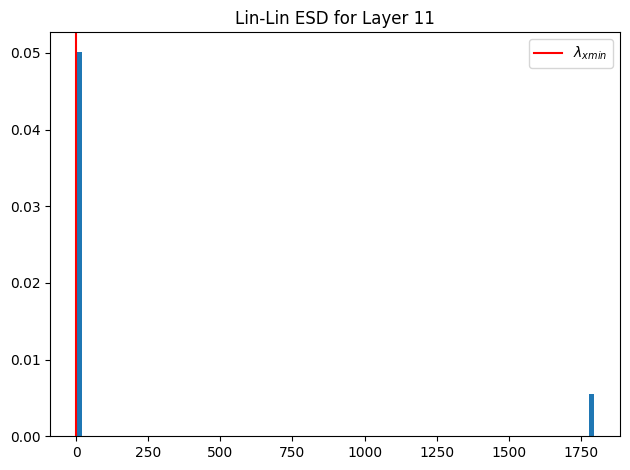

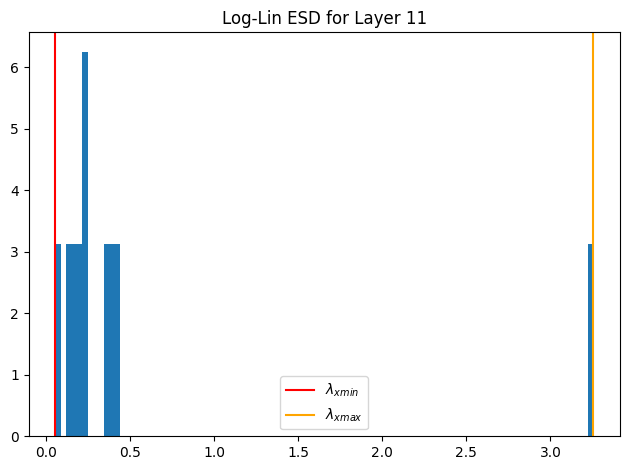

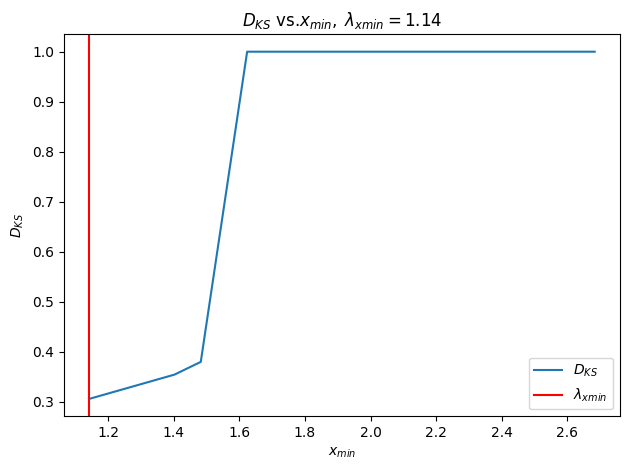

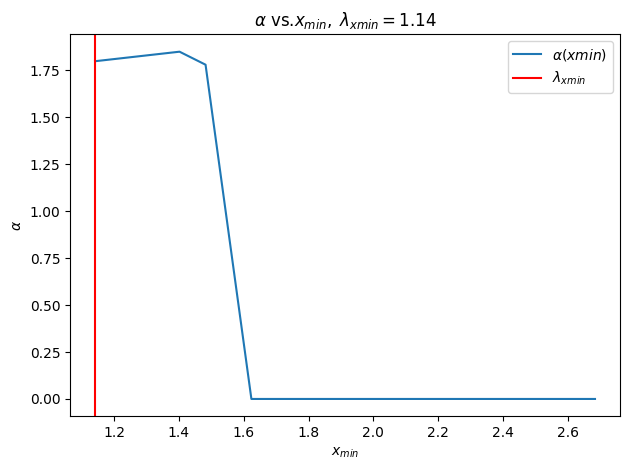

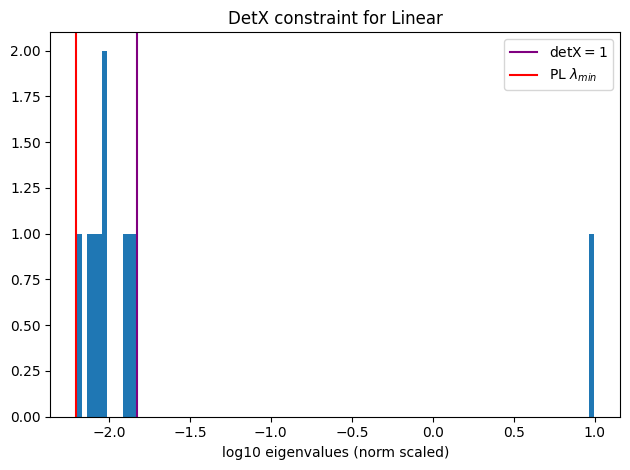

,layer_id,name,D,M,N,Q,alpha,alpha_weighted,detX_num,detX_val,...,sigma,spectral_norm,stable_rank,status,sv_max,sv_min,warning,weak_rank_loss,xmax,xmin
0,3,Linear,0.026190,784,1792,2.285714,1.846887,5.553418,326,8.392263,...,0.041177,1016.032643,20.255622,success,31.875267,0.916248,over-trained,0,1016.032643,5.955615
1,7,Linear,0.014756,896,1792,2.000000,1.951492,5.953672,343,7.501090,...,0.050079,1124.168360,17.019667,success,33.528620,0.703458,over-trained,0,1124.168360,7.058566
2,11,Linear,0.305348,10,896,89.600000,1.798094,5.851166,2,2.683748,...,0.252379,1795.119827,1.009148,success,42.368854,1.068249,over-trained,0,1795.119827,1.141156


<Figure size 640x480 with 0 Axes>

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import weightwatcher as ww

watcher = ww.WeightWatcher(model=model)
details = watcher.analyze(plot=True, detX=True)
details